<a href="https://colab.research.google.com/github/ReeganCodemaster/CatVsDogs/blob/main/Copy_of_retrain_existing_model_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import some library code


*   `tensorflow` is the machine learning library we're using
*   `os` helps us interact with files and folders
*   `matplotlib` is for displaying charts and images
*   `numpy` helps us work with data to prepare it for `tensorflow` and review it afterwards


In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

This code gets the data you will use to train your model: pictures of cats and dogs.


In [2]:
import tensorflow_datasets as tfds
(raw_training, raw_validation, raw_testing), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteX6BOT4/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.



This function takes an image and a label as inputs. The image is then converted into three sets of numbers representing the colours red, green, and blue for every pixel in the image. The combination of these colours can form any other colour. The red, green, and blue values are then converted from numbers between 0 and 255, to numbers between -1 and 1, as the model has been trained to work with values in that range. Finally, the image is resized based on the `IMAGE_SIZE` constant, to match the size the model was previously trained on. In this case, it's a 160 by 160 pixel square.


In [3]:
IMAGE_SIZE = 160

training_data = None

# Resize an image, and convert it into a form that tensorflow can read more easily 
def prep_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image, label

training_data = raw_training.map(prep_image)
validation_data = raw_validation.map(prep_image)
testing_data = raw_testing.map(prep_image)

These are versions of the functions from the previous project, so you can use them to test your model.

In [4]:
def get_image_from_url(image_url):
  # If the temporary test_image.jpg file already exists, 
  # delete it so a new one can be made.
  if os.path.exists('/root/.keras/datasets/test_image.jpg'):
    os.remove('/root/.keras/datasets/test_image.jpg')

  image_path = tf.keras.utils.get_file('test_image.jpg', origin=image_url)
  return image_path

def print_predictions(predictions):
    for (prediction, number) in zip(predictions[0], range(1, len(predictions[0])+1)):
      print('{}. {} {:.2f}%'.format(number, prediction[1], prediction[2]*100))

def predict_with_old_model(image_url):
  image_path = get_image_from_url(image_url)
  
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

  plt.figure()
  plt.imshow(image)

  image = tf.keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  prediction_result = original_model.predict(image, batch_size=1)
  predictions = tf.keras.applications.imagenet_utils.decode_predictions(prediction_result, top=15)

  print_predictions(predictions)

def predict_image(image_url):
  image_path = get_image_from_url(image_url)
  
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))

  plt.figure()
  plt.imshow(image)

  image = tf.keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  prediction_result = model.predict(image, batch_size=1)
  labels = metadata.features['label'].names
  print(labels[prediction_result.argmin()])

Import and test the MobileNetV2 model that you will retrain.



In [5]:
  IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
  original_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False)
  original_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In the cell below, split your images into training, validation, and testing data.

In [25]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

training_batches = training_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
testing_batches = testing_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

Add the new layers to the model, to allow it to be retrained.

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)

model = tf.keras.Sequential([
  original_model,
  global_average_layer,
  prediction_layer                            
]
)

BASE_LEARNING_RATE = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=BASE_LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Set up your training epochs and train the new layers of the model.

In [ ]:
TRAINING_EPOCHS = 10
with tf.device('/device:GPU:0'):
  history = model.fit(training_batches,
                      epochs=TRAINING_EPOCHS,
                      validation_data=validation_batches)


Epoch 1/10
291/291 [==============================] - 52s 164ms/step - loss: 3.1635 - accuracy: 0.4224 - val_loss: 0.7009 - val_accuracy: 0.4213
Epoch 2/10
291/291 [==============================] - 49s 162ms/step - loss: 0.7080 - accuracy: 0.4261 - val_loss: 0.6928 - val_accuracy: 0.4286
Epoch 3/10
291/291 [==============================] - 48s 161ms/step - loss: 0.6972 - accuracy: 0.4327 - val_loss: 0.6928 - val_accuracy: 0.4304
Epoch 4/10
291/291 [==============================] - 48s 160ms/step - loss: 0.6949 - accuracy: 0.4421 - val_loss: 0.6928 - val_accuracy: 0.4351
Epoch 5/10
291/291 [==============================] - 48s 161ms/step - loss: 0.6946 - accuracy: 0.4430 - val_loss: 0.6923 - val_accuracy: 0.4450
Epoch 6/10
291/291 [==============================] - 48s 160ms/step - loss: 0.6952 - accuracy: 0.4484 - val_loss: 0.6923 - val_accuracy: 0.4510
Epoch 7/10
291/291 [==============================] - 49s 162ms/step - loss: 0.6929 - accuracy: 0.4499 - val_loss: 0.6923 - val_ac

Use the `predict_image` function to test your model.

196608/191807 [==============================] - 0s 1us/step
dog


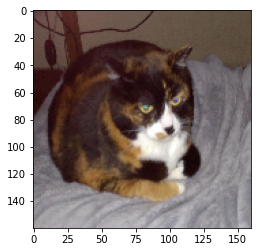

In [24]:
predict_image('https://db3pap006files.storage.live.com/y4mzgUT9mpUZvbzgsYfWqTgOnAKxFwxxtuna06JnR2AN7SctaBxpPBIPlvG-5TNw5Zd-EWH5m870R0CdxNLWf0WBprNvj7BJ20NeOCMKvwYjtzMUNbcmTSKo4eJVS_OqitGJxzHw2evaleeUW1QW8gQwxbPX165fgVG3Imsu-dADqA28QuHwDgUQWwvWY6uYmXB?width=1538&height=1304&cropmode=none')